In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

from pandas.plotting import lag_plot

from datetime import datetime, date, timedelta

In [2]:
flist = matplotlib.font_manager.get_fontconfig_fonts()
names = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in flist]
print (names)

['DejaVu Serif', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans Mono', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono']


In [4]:
def import_process_data_for_eda():
    """
    Imports master
    """
    caiso = pd.read_csv('data/caiso_master.csv')
    caiso.drop('Unnamed: 0', axis=1, inplace=True)
    caiso['INTERVAL_START_PT'] = pd.to_datetime(caiso['INTERVAL_START_PT']).apply(lambda x: x.replace(tzinfo=None))
    caiso['INTERVAL_END_PT'] = pd.to_datetime(caiso['INTERVAL_END_PT']).apply(lambda x: x.replace(tzinfo=None))
    caiso['date_hour_start'] = pd.to_datetime(caiso['date_hour_start']).apply(lambda x: x.replace(tzinfo=None))
    caiso['OPR_DT_PT'] = pd.to_datetime(caiso['OPR_DT_PT'])
    caiso.set_index('INTERVAL_START_PT', inplace=True)
    caiso.rename({'HH_$_million_BTU_not_seasonal_adj': 'HH_$_mill_BTU', 'total_mw':'total_gen'},axis=1, inplace=True)
    caiso['HH_$_mill_BTU'] = pd.to_numeric(caiso['HH_$_mill_BTU'])
    apr_30_20 = caiso[caiso['OPR_DT_PT'] == '2020-04-30']
    end_may20_hrly = pd.concat([apr_30_20, apr_30_20, apr_30_20, apr_30_20], axis=0)
    beg_may_arr = pd.date_range(start='2020-05-01', end='2020-05-05', freq='H')[:-1]
    end_may20_hrly.set_index(beg_may_arr, inplace=True)
    caiso_eda = pd.concat([caiso, end_may20_hrly], axis=0)
    caiso_eda.sort_index()
    caiso_eda['total_re'] = caiso_eda['solar'] + caiso_eda['wind']
#     caiso_eda['prcnt_re_gen'] = caiso_eda['total_re'] / caiso_eda['total_gen']
    caiso_eda = caiso_eda[caiso_eda['OPR_DT_PT'] != '2020-05-05']
    return caiso_eda

In [3]:
# Use in "src" directory.

def import_process_data_for_eda():
    """
    Prepares CAISO master dataset for EDA by filling in May 1 to 4 with the data from April 27 to 30 and removing the data provided for May 5.
    CAISO OASIS system seems to experienced and error in the beginning of May 2020.
    
    Parameters
    ----------
    caiso : dateframe
        Final CAISO dataset that's comprised of all three hub's LMPs and exogenous variables, e.g. energy generation.
        
    Returns
    -------
    caiso_eda : dataframe
        A dateset that's been prepared for visualizations.
        
    """
    caiso = pd.read_csv('data/caiso_master.csv')
    caiso.drop('Unnamed: 0', axis=1, inplace=True)
    caiso['INTERVAL_START_PT'] = pd.to_datetime(caiso['INTERVAL_START_PT']).apply(lambda x: x.replace(tzinfo=None))
    caiso['INTERVAL_END_PT'] = pd.to_datetime(caiso['INTERVAL_END_PT']).apply(lambda x: x.replace(tzinfo=None))
    caiso['date_hour_start'] = pd.to_datetime(caiso['date_hour_start']).apply(lambda x: x.replace(tzinfo=None))
    caiso['OPR_DT_PT'] = pd.to_datetime(caiso['OPR_DT_PT'])
    caiso.set_index('INTERVAL_START_PT', inplace=True)
    caiso.rename({'HH_$_million_BTU_not_seasonal_adj': 'HH_$_mill_BTU', 'total_mw':'total_gen'},axis=1, inplace=True)
    caiso['HH_$_mill_BTU'] = pd.to_numeric(caiso['HH_$_mill_BTU'])
    apr_30_20 = caiso[caiso['OPR_DT_PT'] == '2020-04-30']
    end_may20_hrly = pd.concat([apr_30_20, apr_30_20, apr_30_20, apr_30_20], axis=0)
    beg_may_arr = pd.date_range(start='2020-05-01', end='2020-05-05', freq='H')[:-1]
    end_may20_hrly.set_index(beg_may_arr, inplace=True)
    caiso_eda = pd.concat([caiso, end_may20_hrly], axis=0)
    caiso_eda.sort_index()
    caiso_eda['total_re'] = caiso_eda['solar'] + caiso_eda['wind']
#     caiso_eda['prcnt_re_gen'] = caiso_eda['total_re'] / caiso_eda['total_gen']
    caiso_eda = caiso_eda[caiso_eda['OPR_DT_PT'] != '2020-05-05']
    return caiso_eda

In [4]:
caiso_eda = import_process_data_for_eda()
date_arr = caiso_eda.index
np15_lmp = caiso_eda['$_MWH_np15']
sp15_lmp = caiso_eda['$_MWH_sp15']
zp26_lmp = caiso_eda['$_MWH_zp26']
all_lmp = [np15_lmp, sp15_lmp, zp26_lmp]

# For Py File

In [5]:
def plot_day_ahead_hourly_prices(date_rng, lmp_curve, hub_name):
    """
    Graphs the hourly price on a scatter plot.
    
    Parameters
    ----------
    date_rng : arr
        Data range used for x-axis.
    
    lmp_curve: arr
        Comprised of the hourly prices from the selected CAISO hub.
        
    Returns
    -------
        
    """
    
    plt.figure(figsize=(18,7))
    
    ax = sns.scatterplot(x=date_rng, y=lmp_curve)
    ax.set_xlim(date_rng.min(),date_rng.max())
    ax.set_ylabel('$ / MWh', fontsize=12)
#     ax.set_style('seaborn-white')
    ax.set_title(f'{hub_name} Day-Ahead Hourly Prices', fontsize=24, fontweight='bold')
    plt.tight_layout();

def plot_price_curve_box_plot(hours_day, lmp_curve, df):
    """
    Shows the distribution of hourly prices for each our of the day for the provided duration.
    
    Parameters
    ----------
    lmp_hour : str
        Name of the column in the provided dataframe that contains the hourly prices.
    
    hours_day : str
        Name of the column in the provided dataframe that contains the hour ending for each of the provided historic prices.
    
    df : dataframe
        Dataframe that contains historic electricity prices.        
    
    Return
    -------
    
    """
    
    plt.figure(figsize=(20,8))
    ax = sns.boxplot(x=hours_day, y=lmp_curve, palette='Set3', data=df)
    ax.set_title('Distribution of NP-15 Wholesale Electricity Prices', fontsize=24, fontweight='bold')
    ax.set_ylabel('$ / MWh', fontsize=12)
    ax.set_xlabel('Hour Ending', fontsize=16)
    ax.set_xlim(-0.5, 23.5)
    plt.tight_layout();

def draw_lag_plots(lmp_curves_list, hub_names, lag=1):
    """
    Plots the lag plot to evaluate the time-series data's autocorrelation.
    
    Parameters
    ----------
    lmp_curves_list : list of arrays
        A list comprised of historic price curves.
    
    hub_names : list of strings
        Names of the CAISO hubs.
    
    lag : int
        The difference in time of the two datapoints that are being evaluated for correlation.

    """
    fig, axs = plt.subplots(nrows=1, ncols=len(hub_names), sharey=True, figsize=(20,6))
    mpl.rcParams['font.family'] = "Times New Roman"

    for i, curve, h in zip(range(len(hub_names)), lmp_curves_list, hub_names):
        lag_plot(curve, ax=axs[i], c='blue', alpha=0.5, lag=24)
        axs[i].set_title(f"{h} Lag Plot - 24 Hours", fontsize=16, fontweight='bold')
    
    plt.tight_layout();


def draw_moving_avg_plot(prcnt_re_gen, daily_date_rng, num_days):    
    """
    Plots the percentage of energy derived from renewable resources and the 14-day moving average.

    Parameters
    ----------
    prcnt_re_gen : arr
        Each data point is the daily percentage of energy that was derived from renewable resources.
    
    daily_date_rng : arr
        Date range that  will make up the x-axis. Values should be daily.
    
    num_days : int
        Number of days to use to calculate the moving average.
    
    Return
    -------
    """

    fig, ax = plt.subplots(figsize=(18,8))
    
    mpl.rcParams['font.family'] = "Times New Roman"
    
    rolling = caiso_daily['prcnt_re_gen'].rolling(num_days).mean()
    daily_date_arr = caiso_daily['OPR_DT_PT']

    ax.plot(daily_date_rng, caiso_daily['prcnt_re_gen'], color='lightgrey', label='Actual')
    ax.plot(daily_date_rng, rolling, color='green', linewidth=3, label=f'{num_days}-day Moving Avg.')
    ax.set_ylabel('% of Total Generation', fontsize=12)
    ax.set_title('Energy Generation Derived from Renewable Resources', fontsize=22, fontweight='bold')
    ax.set_xlim(daily_date_rng.min(), daily_date_rng.max())
    ax.legend()
    plt.tight_layout();

# Test Functions

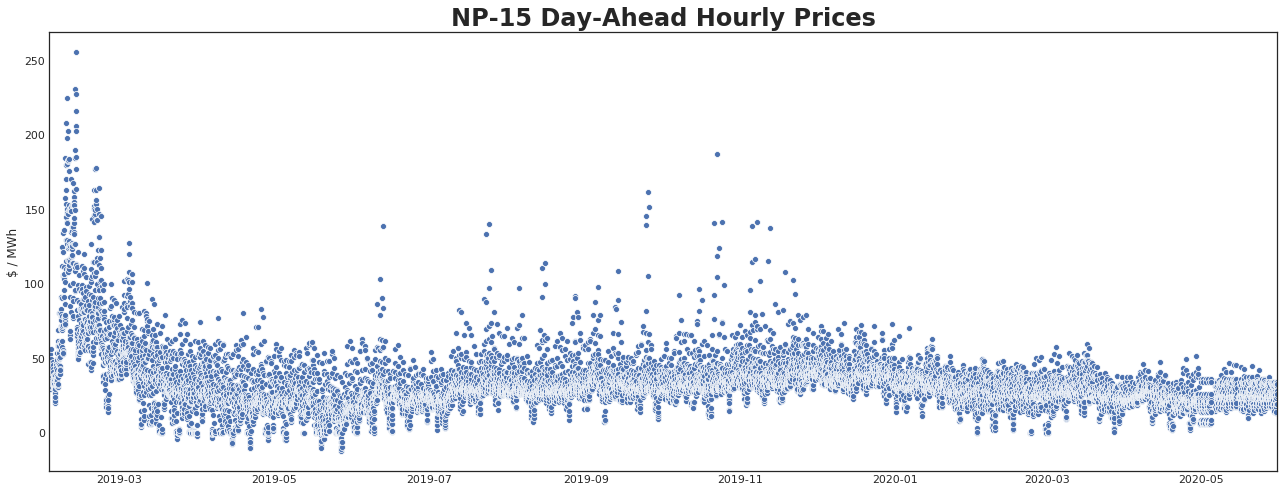

In [50]:
plot_day_ahead_hourly_prices(date_arr, np15_lmp, 'NP-15')

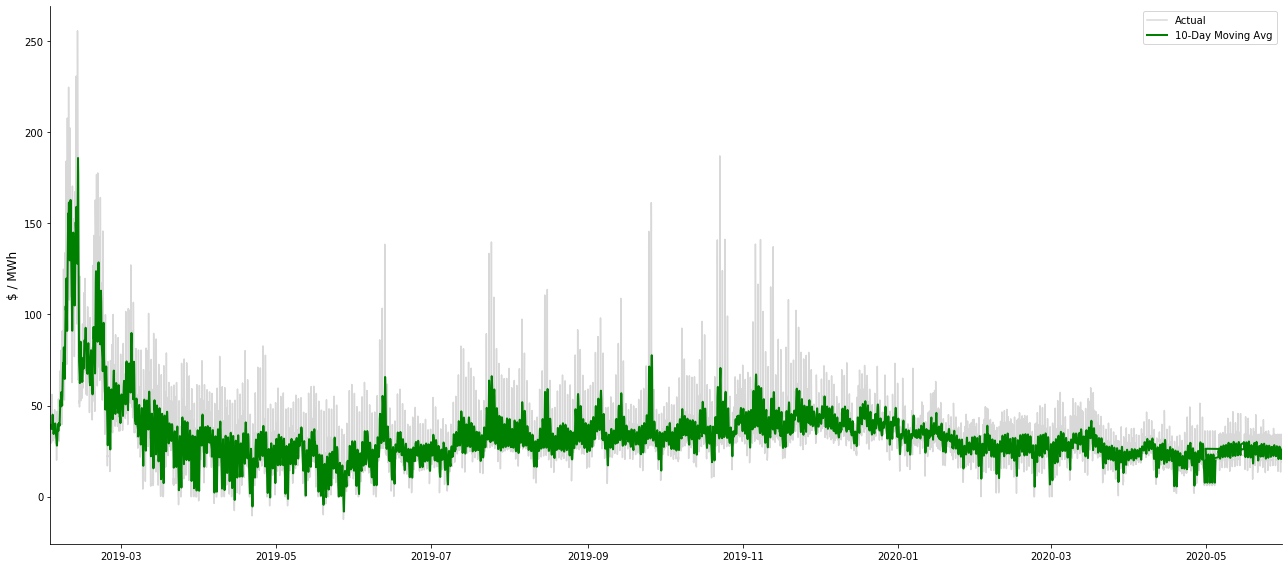

In [24]:
fig, ax = plt.subplots(figsize=(18,8))
# plt.rcParams['font.family'] = 'garamond'
rolling10= np15_lmp.rolling(10).mean()
# rolling14 = caiso_daily['prcnt_re_gen'].rolling(14).mean()
# daily_date_arr = caiso_daily['OPR_DT_PT']

ax.plot(date_arr, np15_lmp, color='grey', alpha=0.3, label='Actual')
ax.plot(date_arr, rolling10, color='green', linewidth=2, label='10-Day Moving Avg')
ax.set_ylabel('$ / MWh', fontsize=12)

ax.set_xlim(date_arr.min(), date_arr.max())
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout();

plt.savefig('preso/np15_moving_avg.png')

findfont: Font family ['garamond'] not found. Falling back to DejaVu Sans.


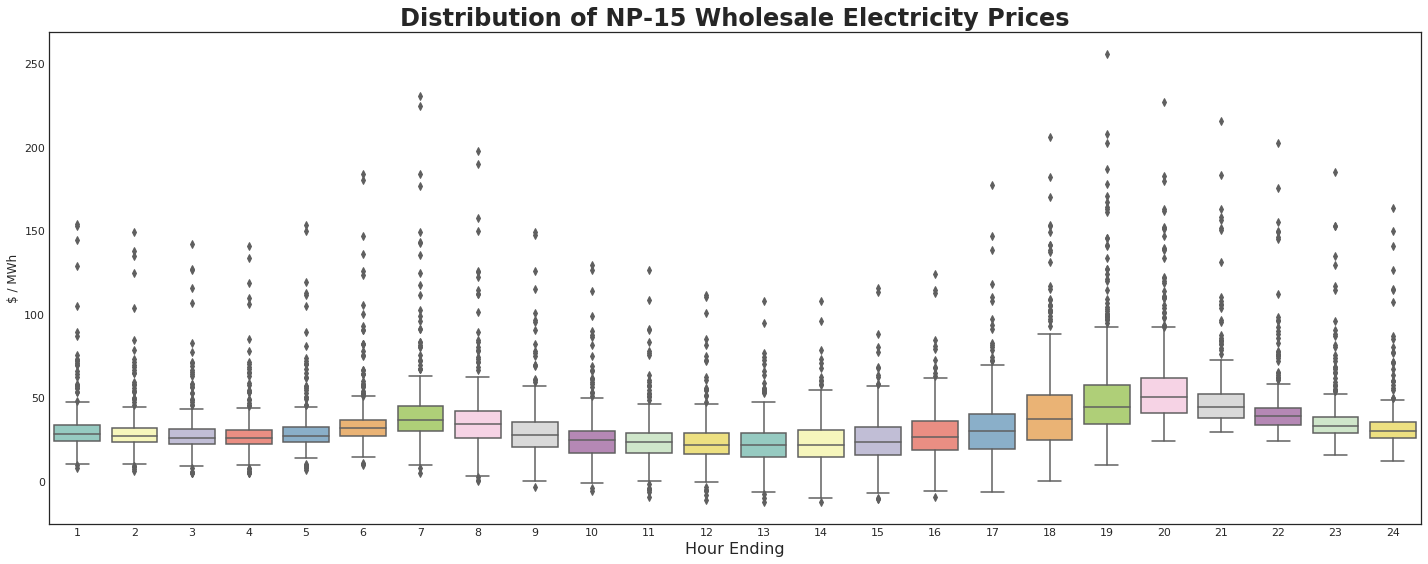

In [57]:
plot_price_curve_box_plot('OPR_HR_PT', '$_MWH_np15', caiso_eda)
plt.savefig('images/np15_hourly_distribution.png')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


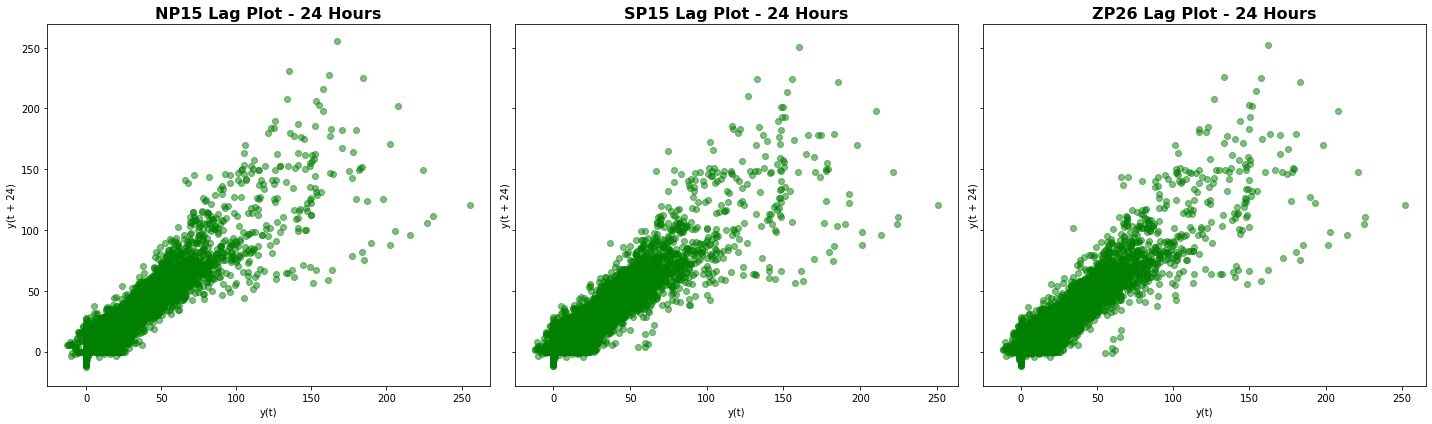

In [33]:
draw_lag_plots(all_lmp, hubs, lag=24)

In [32]:
draw_moving_avg_plot(caiso_daily['prcnt_re_gen'], daily_date_arr, 14)


NameError: name 'caiso_daily' is not defined

## Day Ahead Hourly Prices

High average day-ahead priceswere frequent in the first quarter with prices greater than 100/MWh occurring around 8 percent of
intervals compared with around 1.3 percent in the same quarter of 2018. Average day-ahead prices
greater than 100/MWh in just the month of February occurred in around 22.5 percent of intervals,
largely driven by high natural gas prices at trade hubs located within the ISO area. 


In [8]:
draw_moving_avg_plot(prcnt_re_gen, daily_date_rng, num_days)
np.arange(1,25)
    

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

findfont: Font family ['garamond'] not found. Falling back to DejaVu Sans.


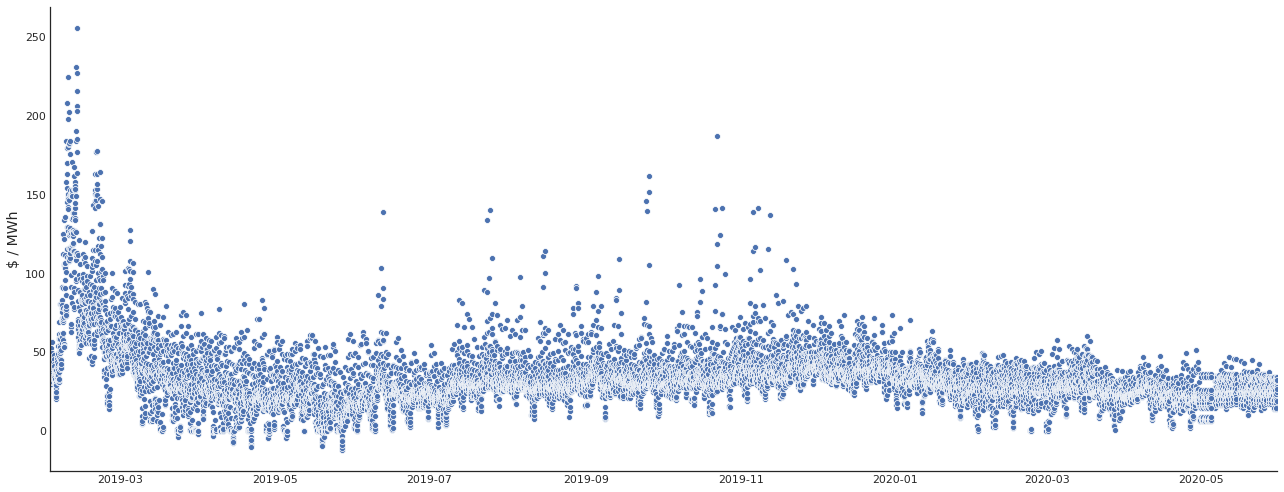

In [53]:
plt.figure(figsize=(18,7))

ax = sns.scatterplot(x=date_arr, y=np15_lmp)
ax.set_xlim(date_arr.min(),date_arr.max())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('$ / MWh', fontsize=14)
# ax.set_title('NP15 Day Ahead Hourly Prices', fontsize=24, fontweight='bold')
plt.tight_layout();

plt.savefig('preso/np15_day_ahead_price.png')

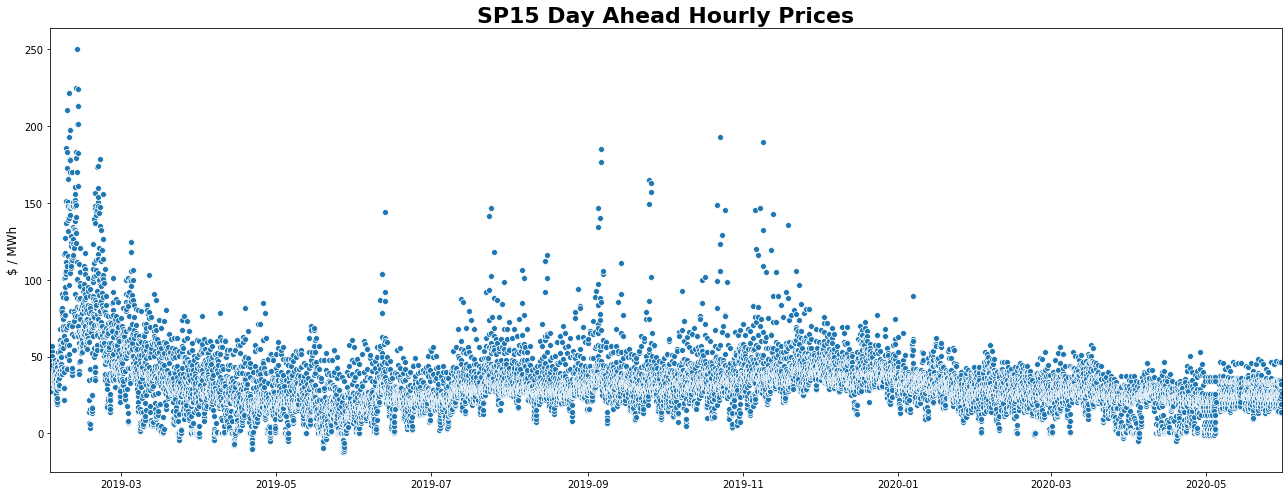

In [22]:
plt.figure(figsize=(18,7))
ax = sns.scatterplot(x=date_arr, y=sp15_lmp)
ax.set_xlim(date_arr.min(),date_arr.max())
ax.set_ylabel('$ / MWh', fontsize=12)
ax.set_title('SP15 Day Ahead Hourly Prices', fontsize=22, fontweight='bold')
plt.tight_layout();

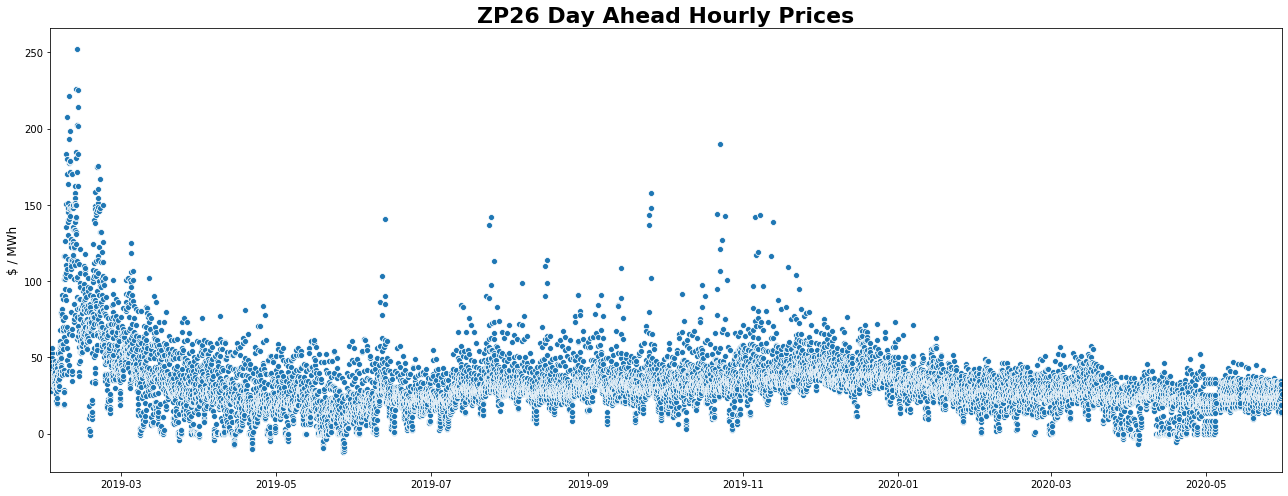

In [24]:
plt.figure(figsize=(18,7))
ax = sns.scatterplot(x=date_arr, y=zp26_lmp)
ax.set_xlim(date_arr.min(),date_arr.max())
ax.set_ylabel('$ / MWh', fontsize=12)
ax.set_title('ZP26 Day Ahead Hourly Prices', fontsize=22, fontweight='bold')
plt.tight_layout();

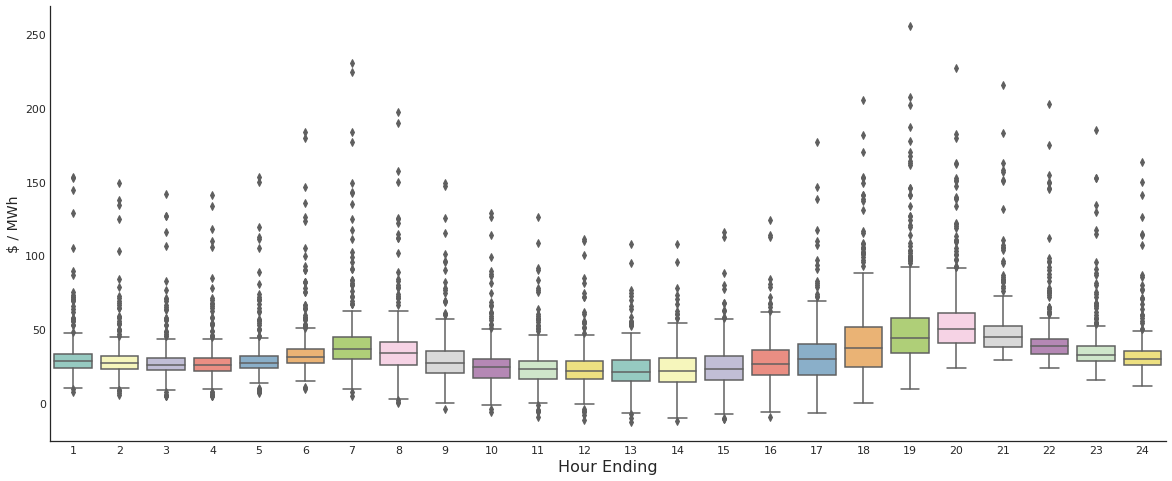

In [60]:
plt.figure(figsize=(20,8))
ax = sns.boxplot(x='OPR_HR_PT', y='$_MWH_np15', palette='Set3', data=caiso_eda)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('$ / MWh', fontsize=14)
ax.set_xlabel('Hour Ending', fontsize=16)
ax.set_xlim(-0.5, 23.5)

plt.savefig('preso/np15_hourly_distribution.png', bbox_inches='tight')

## Time Series Lag Scatter Plots

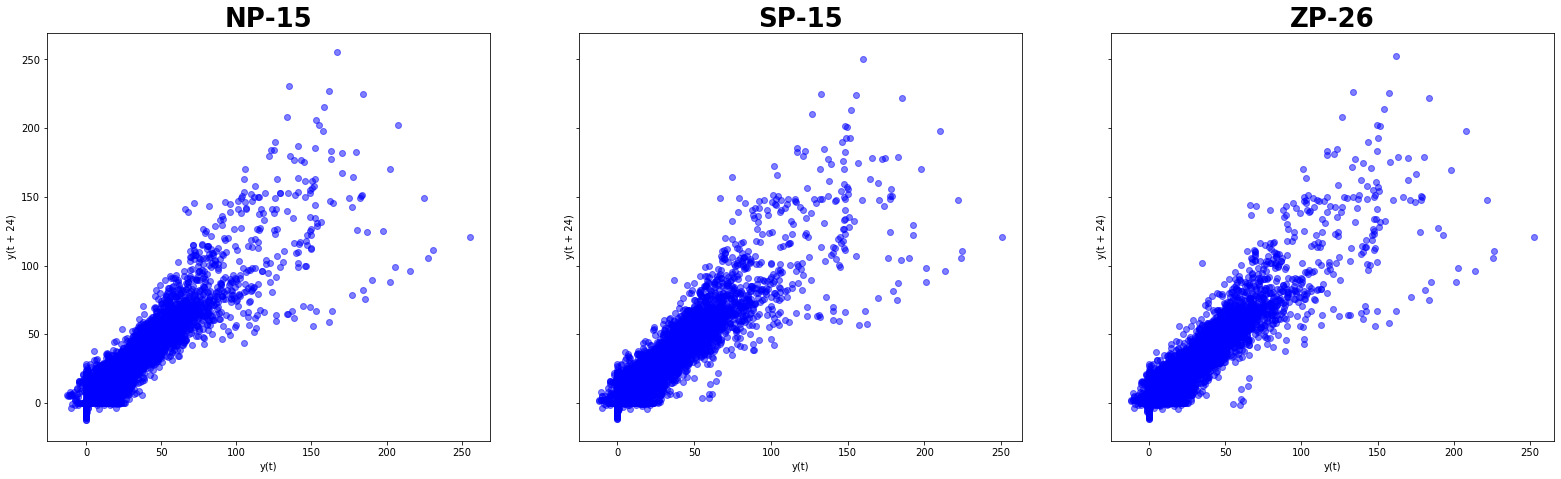

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(27,7.5))
hubs =  ['NP-15', 'SP-15', 'ZP-26']

mpl.rcParams['font.family'] = "Granjon"
for i, curve, h in zip(range(len(hubs)), all_lmp, hubs):
    lag_plot(curve, ax=axs[i], c='blue', alpha=0.5, lag=24)
    axs[i].set_title(f"{h}", fontsize=26, fontweight='bold')

plt.savefig('preso/lag_plot.png', bbox_inches='tight', pad_inches=0.05 )

In [27]:
caiso_daily = caiso_eda.groupby('OPR_DT_PT').agg(func='sum').reset_index()
# caiso_daily.drop('prcnt_re_gen', axis=1, inplace=True) 
caiso_daily['prcnt_re_gen'] = (caiso_daily['solar'] + caiso_daily['wind']) / caiso_daily['total_gen']

In [ ]:
def fit_moving_average_trend(series, window=6):
#    return pd.rolling_mean(series, window, center=True)
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
       moving_avg = seris.rolling(window, center=True).mean()

    plot_trend_data(ax, name, series)
    ax.plot(series.index.date, moving_average_trend)

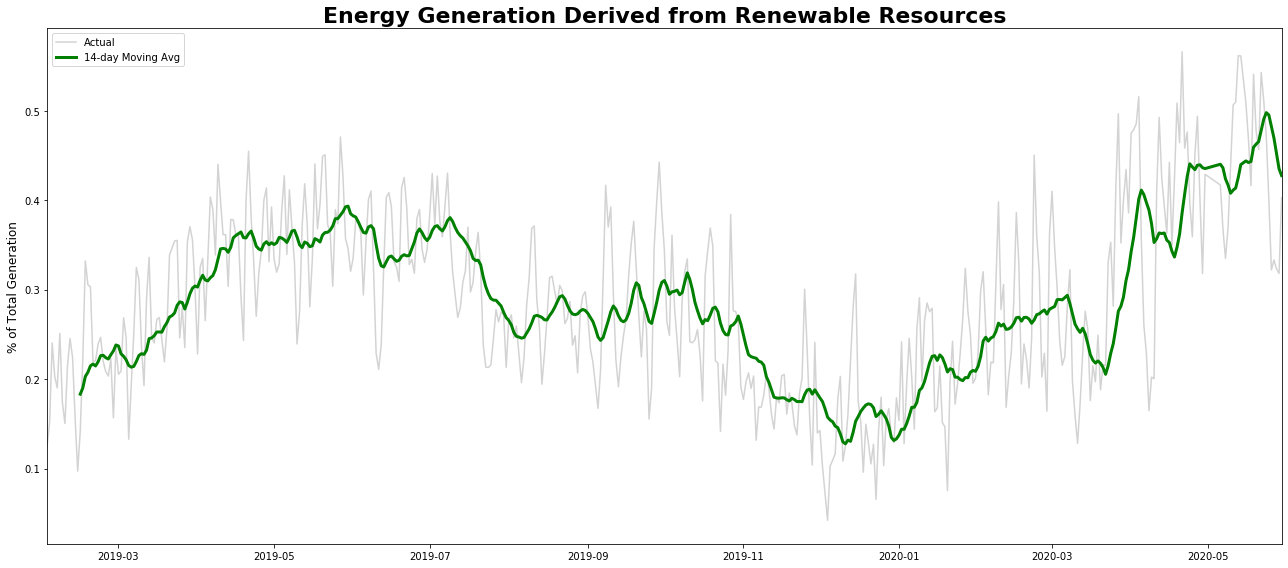

In [28]:
fig, ax = plt.subplots(figsize=(18,8))
# plt.rcParams['font.family'] = 'garamond'
rolling7= caiso_daily['prcnt_re_gen'].rolling(7).mean()
rolling14 = caiso_daily['prcnt_re_gen'].rolling(14).mean()
daily_date_arr = caiso_daily['OPR_DT_PT']

ax.plot(daily_date_arr, caiso_daily['prcnt_re_gen'], color='lightgrey', label='Actual')
ax.plot(daily_date_arr, rolling14, color='green', linewidth=3, label='14-day Moving Avg')
ax.set_ylabel('% of Total Generation', fontsize=12)
ax.set_title('Energy Generation Derived from Renewable Resources', fontsize=22, fontweight='bold')
ax.set_xlim(daily_date_arr.min(), daily_date_arr.max())
ax.legend()
plt.tight_layout();

# plt.savefig('images/energy_derived_renew.png')

In [89]:
daily_date_arr

RangeIndex(start=0, stop=479, step=1)